<center><h1>Edogeneity detection and instrument selection via solar-based graph learning(linear)</h1></center>

<center><h2>Author: Ning Xu </h2></center>

<center><h3> xuningandy@outlook.com </h3></center>

Please note that
* this package is a purely CPU-based python package
* for the latest version of the package, click [here](https://github.com/isaac2math)

# #1. reset python kernel

In [1]:
%reset -f

---

# #2. import packages

In [11]:
import numpy             as np
import statsmodels.api   as sm
import pandas            as pd
import matplotlib.pyplot as plt
import statsmodels.api   as sm
import seaborn           as sns

from sklearn.linear_model       import LassoLarsCV, LassoCV, ElasticNetCV
from solar                      import solar
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv            import IV2SLS, IVGMM, IVGMMCUE  #IV regression and test
from collections                import OrderedDict
from linearmodels.iv.results    import compare

---

# #3. load house price data

In [12]:
linTB = pd.read_csv("Data2010.csv")

## #3(a). rename variables

In [13]:
linTB.rename(columns={'Tot_P_P':'TotPop',
                      'Mean_age_persons':'AgeSA1',
                      'Australian_citizen_P':'Aus',
                      'Average_num_psns_per_bedroom':'psn-per-bedroom',
                      'Average_household_size':'household_size',
                      'FinalResultEventPrice': 'Price',
                      'Lang_spoken_home_Eng_only_P':'Eng-speak',
                      'Mean_mortgage_repay_monthly':'Mortgage',
                      'Mean_Tot_prsnl_inc_weekly':'Inc',
                      'Mean_rent_weekly':'Rent',
                      'Mean_Tot_fam_inc_weekly':'FamInc'}, 
                 inplace=True)
linTB = linTB.drop(['Unnamed: 0'],axis=1)
linTB = linTB.dropna()
linTB['const'] = 1
linTB.columns

#drop larger than 1500
#linTB['index'] = linTB['AreaSize'] <=4000
#linTB = linTB[linTB['index']==1]

Index(['TotPop', 'Eng-speak', 'Aus', 'AgeSA1', 'Mortgage', 'Inc', 'Rent',
       'FamInc', 'psn-per-bedroom', 'household_size', 'TVO2010', 'TPO2010',
       'TVO2009', 'TPO2009', 'Suburb_Area', 'AreaSize', 'Bedrooms', 'Baths',
       'Parking', 'Airport', 'Beach', 'Cemetery', 'ChildCare',
       'CommunityFacility', 'Club', 'Gaol', 'GeneralHospital', 'GolfCourt',
       'High', 'Lib', 'MedCenter', 'Museum', 'Park', 'PO', 'Police',
       'PreSchool', 'PrimaryHigh', 'Primary', 'RailStat', 'Rubbish', 'Sewage',
       'SportsCenter', 'SportsCourtField', 'Swimming', 'Tertiary', 'DistBound',
       'ICSEA', 'ReadingY3', 'WritingY3', 'SpellingY3', 'GrammarY3',
       'NumeracyY3', 'ReadingY5', 'WritingY5', 'SpellingY5', 'GrammarY5',
       'NumeracyY5', 'Price', 'const'],
      dtype='object')

In [14]:
linTB['AreaSize'].describe()

count    11974.000000
mean      1848.073242
std       4688.261157
min          0.000000
25%        478.000000
50%        724.000000
75%       1554.250000
max      63156.000000
Name: AreaSize, dtype: float64

In [15]:
linTB.to_csv('House2010_linear.csv')
Y_linear = linTB[['Price']]
X_linear = linTB.drop(columns=['Price'])
X_linear.columns

Index(['TotPop', 'Eng-speak', 'Aus', 'AgeSA1', 'Mortgage', 'Inc', 'Rent',
       'FamInc', 'psn-per-bedroom', 'household_size', 'TVO2010', 'TPO2010',
       'TVO2009', 'TPO2009', 'Suburb_Area', 'AreaSize', 'Bedrooms', 'Baths',
       'Parking', 'Airport', 'Beach', 'Cemetery', 'ChildCare',
       'CommunityFacility', 'Club', 'Gaol', 'GeneralHospital', 'GolfCourt',
       'High', 'Lib', 'MedCenter', 'Museum', 'Park', 'PO', 'Police',
       'PreSchool', 'PrimaryHigh', 'Primary', 'RailStat', 'Rubbish', 'Sewage',
       'SportsCenter', 'SportsCourtField', 'Swimming', 'Tertiary', 'DistBound',
       'ICSEA', 'ReadingY3', 'WritingY3', 'SpellingY3', 'GrammarY3',
       'NumeracyY3', 'ReadingY5', 'WritingY5', 'SpellingY5', 'GrammarY5',
       'NumeracyY5', 'const'],
      dtype='object')

---

# #4. generate X and Y for variable selection

In [16]:
X_linear_input = np.array(X_linear)
Y_linear_input = np.array(Y_linear)

x = np.arange(1,10,0.01)
y = np.matrix(I)
x = np.arange(1,10,0.01)
y = np.matrix(I)

In [17]:
obs     = X_linear_input.shape[0]

Y_linear_input.shape = (obs,)

---

# #5. compute CV coordinate descend (CV-cd), CV lars for lasso (CV-lars-lasso), CV elastic net (CV-en) and solar regression 

In [18]:
# CV coordinate descend (CV-cd)

RegLinear1 = LassoCV(cv=10, normalize = True, random_state=0)
RegLinear1.fit(X_linear_input, Y_linear_input)

LinearLassoCV_ceof = RegLinear1.coef_
LinearLassoCV_ind  = np.nonzero(LinearLassoCV_ceof)


# CV-lars-lasso

np.random.seed(0)

RegLinear2 = LassoLarsCV(cv=10)
RegLinear2.fit(X_linear_input,Y_linear_input)

LinearLasso_lars_ceof = RegLinear2.coef_
LinearLasso_lars_ind  = np.nonzero(LinearLasso_lars_ceof)

# CV-en

RegLinear3 = ElasticNetCV(normalize=True, random_state=0)
RegLinear3.fit(X_linear_input,Y_linear_input)

# solar

Y_linear_input.shape = (obs,1)

np.random.seed(0)

RegLinear4 = solar( X_linear_input,Y_linear_input, 10, -0.02, lasso = False)
LinearSolar_coef, LinearOpt_c, LinearTest_error, LinearQc_list, _, _, _, _ = RegLinear4.fit()

LinearSolar_ind = np.nonzero(LinearSolar_coef)[0]

---

# #8. the results of variable selection

## #6(c). variable selection by lasso, solar and elastic net

### variables selected by CV-lars-lasso

In [19]:
LinearLasso_lars_active = X_linear.columns[LinearLasso_lars_ind]
print(np.count_nonzero(LinearLasso_lars_ind))
print(LinearLasso_lars_active)

44
Index(['Eng-speak', 'Aus', 'AgeSA1', 'Mortgage', 'Rent', 'FamInc',
       'psn-per-bedroom', 'household_size', 'TVO2009', 'Suburb_Area',
       'AreaSize', 'Bedrooms', 'Baths', 'Parking', 'Airport', 'Beach',
       'Cemetery', 'ChildCare', 'Club', 'GolfCourt', 'High', 'Lib', 'Museum',
       'Park', 'Police', 'PreSchool', 'PrimaryHigh', 'Primary', 'RailStat',
       'Rubbish', 'SportsCenter', 'SportsCourtField', 'Swimming', 'Tertiary',
       'DistBound', 'ICSEA', 'ReadingY3', 'WritingY3', 'SpellingY3',
       'GrammarY3', 'NumeracyY3', 'WritingY5', 'SpellingY5', 'GrammarY5'],
      dtype='object')


### variables selected by CV-cd

In [20]:
LinearLassoCV_active = X_linear.columns[LinearLassoCV_ind]
print(np.count_nonzero(LinearLassoCV_ceof))
print(LinearLassoCV_active)

44
Index(['Eng-speak', 'Aus', 'AgeSA1', 'Mortgage', 'Rent', 'FamInc',
       'psn-per-bedroom', 'household_size', 'TVO2009', 'Suburb_Area',
       'AreaSize', 'Bedrooms', 'Baths', 'Parking', 'Airport', 'Beach',
       'Cemetery', 'ChildCare', 'Club', 'GolfCourt', 'High', 'Lib', 'Museum',
       'Park', 'Police', 'PreSchool', 'PrimaryHigh', 'Primary', 'RailStat',
       'Rubbish', 'SportsCenter', 'SportsCourtField', 'Swimming', 'Tertiary',
       'DistBound', 'ICSEA', 'ReadingY3', 'WritingY3', 'SpellingY3',
       'GrammarY3', 'NumeracyY3', 'WritingY5', 'SpellingY5', 'GrammarY5'],
      dtype='object')


### variables selected by solar

In [21]:
LinearSolar_active = X_linear.columns[LinearSolar_ind]
print(np.count_nonzero(LinearSolar_coef))
print(LinearSolar_active)

9
Index(['Mortgage', 'Rent', 'FamInc', 'Bedrooms', 'Baths', 'Parking', 'Beach',
       'Gaol', 'ICSEA'],
      dtype='object')


### variables selected by CV-en

In [22]:
LinearEn_coef   = RegLinear3.coef_
LinearEn_ind    = np.nonzero(LinearEn_coef)
LinearEn_active = X_linear.columns[LinearEn_ind]
print(np.count_nonzero(LinearEn_coef))
print(LinearEn_active)

57
Index(['TotPop', 'Eng-speak', 'Aus', 'AgeSA1', 'Mortgage', 'Inc', 'Rent',
       'FamInc', 'psn-per-bedroom', 'household_size', 'TVO2010', 'TPO2010',
       'TVO2009', 'TPO2009', 'Suburb_Area', 'AreaSize', 'Bedrooms', 'Baths',
       'Parking', 'Airport', 'Beach', 'Cemetery', 'ChildCare',
       'CommunityFacility', 'Club', 'Gaol', 'GeneralHospital', 'GolfCourt',
       'High', 'Lib', 'MedCenter', 'Museum', 'Park', 'PO', 'Police',
       'PreSchool', 'PrimaryHigh', 'Primary', 'RailStat', 'Rubbish', 'Sewage',
       'SportsCenter', 'SportsCourtField', 'Swimming', 'Tertiary', 'DistBound',
       'ICSEA', 'ReadingY3', 'WritingY3', 'SpellingY3', 'GrammarY3',
       'NumeracyY3', 'ReadingY5', 'WritingY5', 'SpellingY5', 'GrammarY5',
       'NumeracyY5'],
      dtype='object')


# #9. Post-selection regression

## #7(a). post-elastic-net OLS

In [23]:
X_LinearEn   = X_linear[LinearEn_active]
X_LinearEn   = sm.add_constant(X_LinearEn)
OLS_LinearEn = sm.OLS(Y_linear, X_LinearEn)

OLS_LinearEn_result = OLS_LinearEn.fit()
print(OLS_LinearEn_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     254.5
Date:                Mon, 06 Jan 2020   Prob (F-statistic):               0.00
Time:                        13:19:41   Log-Likelihood:            -1.7341e+05
No. Observations:               11974   AIC:                         3.469e+05
Df Residuals:                   11916   BIC:                         3.474e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -8.862e+05   1.87e+0

/home/ning/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## #7(b). post-lasso (CV-cd) OLS

In [24]:
X_LinearLassoCV   = X_linear[LinearLassoCV_active]
Y_LinearLassoCV   = Y_linear
X_LinearLassoCV   = sm.add_constant(X_LinearLassoCV)
OLS_LinearLassoCV = sm.OLS(Y_LinearLassoCV, X_LinearLassoCV)

OLS_LinearLassoCV_result = OLS_LinearLassoCV.fit()
print(OLS_LinearLassoCV_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     328.5
Date:                Mon, 06 Jan 2020   Prob (F-statistic):               0.00
Time:                        13:19:41   Log-Likelihood:            -1.7342e+05
No. Observations:               11974   AIC:                         3.469e+05
Df Residuals:                   11929   BIC:                         3.473e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -8.274e+05   1.74e+05  

## #7(c). post-lasso (lars-lasso) OLS

In [25]:
X_LinearLars   = X_linear[LinearLasso_lars_active]
Y_LinearLars   = Y_linear
X_LinearLars   = sm.add_constant(X_LinearLars)
OLS_LinearLars = sm.OLS(Y_LinearLars, X_LinearLars)

OLS_LinearLars_result = OLS_LinearLars.fit()
print(OLS_LinearLars_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     328.5
Date:                Mon, 06 Jan 2020   Prob (F-statistic):               0.00
Time:                        13:19:42   Log-Likelihood:            -1.7342e+05
No. Observations:               11974   AIC:                         3.469e+05
Df Residuals:                   11929   BIC:                         3.473e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -8.274e+05   1.74e+05  

## #7(d). post-solar OLS

In [26]:
X_Gaol     = X_linear[LinearSolar_active]
X_Gaol     = sm.add_constant(X_Gaol)

OLS_LinearSolar  = sm.OLS(Y_linear, X_Gaol)

OLS_LinearSolar_result = OLS_LinearSolar.fit()

print(OLS_LinearSolar_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     1296.
Date:                Mon, 06 Jan 2020   Prob (F-statistic):               0.00
Time:                        13:19:42   Log-Likelihood:            -1.7410e+05
No. Observations:               11974   AIC:                         3.482e+05
Df Residuals:                   11964   BIC:                         3.483e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.486e+06   9.84e+04    -25.263      0.0

## #7(e). generate a comparison table for post-selection OLS result (slope, significance, $R^2$)

In [27]:
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[OLS_LinearEn_result, OLS_LinearLassoCV_result, 
                                     OLS_LinearLars_result, OLS_LinearSolar_result],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['post-en',
                                         'post-lasso(lars)',
                                         'post-larsso(cd)',
                                         'post-solar'],
                            info_dict=info_dict,
                            regressor_order=['const',
                                             'Bedrooms',
                                             'Baths',
                                             'Parking',
                                             'Beach',
                                             'Gaol',
                                             'ICSEA',
                                             'Mortage',
                                             'Rent',
                                             'FamInc'])

results_table.add_title('Table 1 - Post-selection OLS comparison')

print(results_table)

                    Table 1 - Post-selection OLS comparison
                     post-en     post-lasso(lars) post-larsso(cd)   post-solar  
--------------------------------------------------------------------------------
const             -886234.40***  -827387.49***    -827387.49***   -2486422.15***
                  (186680.91)    (174136.59)      (174136.59)     (98422.98)    
Bedrooms          165639.00***   166225.82***     166225.82***    169510.52***  
                  (6433.57)      (6404.82)        (6404.82)       (6015.37)     
Baths             210101.84***   210600.58***     210600.58***    209626.52***  
                  (8115.07)      (8048.92)        (8048.92)       (8297.24)     
Parking           97790.57***    96883.13***      96883.13***     97623.23***   
                  (6689.35)      (6688.13)        (6688.13)       (6985.67)     
Beach             -5029681.74*** -4051671.57***   -4051671.57***  -796281.77*** 
                  (600061.28)    (262369.00)     

# #8. rectified solar selection

## #8(a). generate correlation table of all variables selected by solar

In [28]:
X_linear[LinearSolar_active].corr()

,Mortgage,Rent,FamInc,Bedrooms,Baths,Parking,Beach,Gaol,ICSEA
Mortgage,1.000000,0.387588,0.549591,0.181471,0.231820,0.132911,-0.234297,-0.194712,0.345316
Rent,0.387588,1.000000,0.489310,0.061113,0.187923,0.069385,-0.256053,-0.217708,0.347929
FamInc,0.549591,0.489310,1.000000,0.085100,0.207115,0.084736,-0.328614,-0.183137,0.586666
Bedrooms,0.181471,0.061113,0.085100,1.000000,0.640027,0.480205,0.034859,0.192444,-0.043633
Baths,0.231820,0.187923,0.207115,0.640027,1.000000,0.428859,-0.072909,0.035303,0.098135
Parking,0.132911,0.069385,0.084736,0.480205,0.428859,1.000000,-0.007429,0.100043,-0.021987
Beach,-0.234297,-0.256053,-0.328614,0.034859,-0.072909,-0.007429,1.000000,0.528157,-0.260294
Gaol,-0.194712,-0.217708,-0.183137,0.192444,0.035303,0.100043,0.528157,1.000000,-0.233874
ICSEA,0.345316,0.347929,0.586666,-0.043633,0.098135,-0.021987,-0.260294,-0.233874,1.000000


## #8(b). compute $\mathrm{corr} \left( \cdot , \mathrm{goal} \right)$ of all variables

In [29]:
goal_corr_table = X_linear.corr()['Gaol']

### focus on those with $\left\vert \mathrm{corr} \left( \cdot , \mathrm{goal} \right) \right\vert \geqslant 0.3$

In [30]:
goal_corr_table[np.abs(goal_corr_table)>=0.3]

household_size       0.308524
Airport              0.715427
Beach                0.528157
Cemetery             0.399691
ChildCare            0.755749
CommunityFacility    0.323157
Club                 0.412455
Gaol                 1.000000
GeneralHospital      0.466243
GolfCourt            0.479372
MedCenter            0.305488
PreSchool            0.472014
Rubbish              0.670654
Sewage               0.448407
Swimming             0.382155
Tertiary             0.482947
Name: Gaol, dtype: float64

### focus on those with $\left\vert \mathrm{corr} \left( \cdot , \mathrm{goal} \right) \right\vert \geqslant 0.5$

In [31]:
goal_corr_table[np.abs(goal_corr_table)>=0.5]

Airport      0.715427
Beach        0.528157
ChildCare    0.755749
Gaol         1.000000
Rubbish      0.670654
Name: Gaol, dtype: float64

## #8(c). check irrepresentable condition 

## $\mathrm{Gaol} = X_{Goal}\gamma + e$, where $X_{Goal} = \left[ \mathrm{Airport}, \mathrm{ChildCare}, \mathrm{Rubbish}, \mathrm{Beach} \right]$

In [32]:
X_Gaol_group = X_linear[['Airport', 'ChildCare', 'Rubbish', 'Beach']]
Y_Gaol_group = X_linear[['Gaol']]

Y_Gaol_group = (Y_Gaol_group - Y_Gaol_group.mean()) / Y_Gaol_group.std()
X_Gaol_group = (X_Gaol_group - X_Gaol_group.mean()) / X_Gaol_group.std()

X_Gaol_group = sm.add_constant(X_Gaol_group)

OLS_Gaol = sm.OLS(Y_Gaol_group, X_Gaol_group)

OLS_Gaol_result = OLS_Gaol.fit()
print(OLS_Gaol_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   Gaol   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                 2.311e+04
Date:                Mon, 06 Jan 2020   Prob (F-statistic):               0.00
Time:                        13:19:45   Log-Likelihood:                -4023.1
No. Observations:               11974   AIC:                             8056.
Df Residuals:                   11969   BIC:                             8093.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -7.91e-15      0.003  -2.56e-12      1.0

### check if $\left\Vert \gamma \right\Vert_1 \geqslant 1$

In [33]:
print('the abs value of regression coef: ', np.sum(np.abs(OLS_Gaol_result.params)))

the abs value of regression coef:  1.3659160731064564


## #8(c). due to the potential IRC violation, add 'Airport' and 'Rubbish' back to post-solar OLS (referred to as the rectified post-solar)

In [34]:
X_rec = X_linear[['Mortgage', 'FamInc', 'Rent',
                 'Bedrooms', 'Baths', 'Parking', 'Beach', 
                 'ICSEA', 'Gaol', 'Airport', 'ChildCare', 
                 'Rubbish']]

X_rec   = sm.add_constant(X_rec)
OLS_rec = sm.OLS(Y_linear, X_rec)

OLS_rec_result = OLS_rec.fit()
print(OLS_rec_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     1059.
Date:                Mon, 06 Jan 2020   Prob (F-statistic):               0.00
Time:                        13:19:46   Log-Likelihood:            -1.7384e+05
No. Observations:               11974   AIC:                         3.477e+05
Df Residuals:                   11961   BIC:                         3.478e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.445e+06   1.12e+05    -12.861      0.0

In [35]:
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table2 = summary_col(results=[OLS_LinearEn_result, OLS_LinearLassoCV_result, 
                                      OLS_LinearLars_result, OLS_rec_result, 
                                      OLS_LinearSolar_result],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['post-en',
                                         'post-lasso(lars)',
                                         'post-larsso(cd)',
                                         'rec post-solar',
                                         'post-solar'],
                            info_dict=info_dict,
                            regressor_order=['const',
                                             'Bedrooms',
                                             'Baths',
                                             'Parking',
                                             'Beach',
                                             'ChildCare',
                                             'Gaol',
                                             'ICSEA',
                                             'Mortgage',
                                             'Rent',
                                             'FamInc',
                                             'Airport',
                                             'Rubbish'])

results_table2.add_title('Table 2 - Post-selection OLS comparison')

print(results_table2)

                            Table 2 - Post-selection OLS comparison
                     post-en     post-lasso(lars) post-larsso(cd) rec post-solar   post-solar  
-----------------------------------------------------------------------------------------------
const             -886234.40***  -827387.49***    -827387.49***   -1445430.40*** -2486422.15***
                  (186680.91)    (174136.59)      (174136.59)     (112390.24)    (98422.98)    
Bedrooms          165639.00***   166225.82***     166225.82***    183893.59***   169510.52***  
                  (6433.57)      (6404.82)        (6404.82)       (6015.93)      (6015.37)     
Baths             210101.84***   210600.58***     210600.58***    203674.28***   209626.52***  
                  (8115.07)      (8048.92)        (8048.92)       (8147.93)      (8297.24)     
Parking           97790.57***    96883.13***      96883.13***     104050.40***   97623.23***   
                  (6689.35)      (6688.13)        (6688.13)       (6

In [36]:
X_corr = X_linear[['Mortgage', 'FamInc', 'Rent',
                 'Bedrooms', 'Baths', 'Parking', 'Beach', 
                 'ICSEA', 'Gaol', 'Airport', 'ChildCare', 
                 'Rubbish']]

Y_corr = (Y_linear  - Y_linear.mean() ) / Y_linear.std()
X_corr = (X_corr - X_corr.mean()) / X_corr.std()

X_corr = sm.add_constant(X_corr)
OLS_corr = sm.OLS(Y_corr, X_corr)

OLS_corr_result = OLS_corr.fit()
print(OLS_corr_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     1059.
Date:                Mon, 06 Jan 2020   Prob (F-statistic):               0.00
Time:                        13:19:47   Log-Likelihood:                -12656.
No. Observations:               11974   AIC:                         2.534e+04
Df Residuals:                   11961   BIC:                         2.543e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.353e-14      0.006    3.7e-12      1.0

# #9. linear PGM estimation based on solar

## this part is finished using R package 'bnlearn', which is fully tested in debian and ubuntu (not tested in windows or mac). Please make sure that either your have R kernel in jupyter or you create R session in Python kernel.

# #10. endogeneity detection and IV estimation using linear PGM

## #10(a). Robust OLS that pretends nothing happens

In [37]:
OLS = IV2SLS(dependent=linTB['Rent'],
            exog=linTB[['const', 'household_size', 'Beach', 
                        'ChildCare', 'Gaol', 'PrimaryHigh', 
                        'Mortgage', 'ICSEA', 'FamInc', 'Inc',
                        'Price']],
            endog=None,
            instruments=None).fit(cov_type='robust')

print(OLS.summary)

                            OLS Estimation Summary                            
Dep. Variable:                   Rent   R-squared:                      0.3462
Estimator:                        OLS   Adj. R-squared:                 0.3457
No. Observations:               11974   F-statistic:                    5429.1
Date:                Mon, Jan 06 2020   P-value (F-stat)                0.0000
Time:                        13:19:48   Distribution:                 chi2(10)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                                
                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------
const             -74.336     32.387    -2.2952     0.0217     -137.81     -10.858
household_size     105.60     4.0883

## #10(b). Robust 2SLS

In [38]:
iv = IV2SLS(dependent=linTB['Rent'],
            exog=linTB[['const', 'household_size', 'Beach', 
                        'ChildCare', 'Gaol', 'PrimaryHigh', 
                        'Mortgage', 'ICSEA', 'FamInc', 'Inc']],
            endog=linTB[['Price']],
            instruments=linTB[['Baths']]).fit(cov_type='robust')

print(iv.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                   Rent   R-squared:                      0.3444
Estimator:                    IV-2SLS   Adj. R-squared:                 0.3439
No. Observations:               11974   F-statistic:                    4918.1
Date:                Mon, Jan 06 2020   P-value (F-stat)                0.0000
Time:                        13:19:48   Distribution:                 chi2(10)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                                
                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------
const             -50.537     34.127    -1.4809     0.1386     -117.42      16.350
household_size     102.56     4.3406

In [39]:
weak_iv1 = IV2SLS(dependent=linTB['Rent'],
            exog=linTB[['const', 'household_size', 'Beach', 
                        'ChildCare', 'Gaol', 'PrimaryHigh', 
                        'Mortgage', 'ICSEA', 'FamInc', 'Inc']],
            endog=linTB[['Price']],
            instruments=linTB[['Bedrooms']]).fit(cov_type='robust')

print(weak_iv1.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                   Rent   R-squared:                      0.3407
Estimator:                    IV-2SLS   Adj. R-squared:                 0.3401
No. Observations:               11974   F-statistic:                    4990.9
Date:                Mon, Jan 06 2020   P-value (F-stat)                0.0000
Time:                        13:19:49   Distribution:                 chi2(10)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                                
                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------
const             -116.40     34.288    -3.3948     0.0007     -183.60     -49.198
household_size     110.95     4.3636

In [40]:
weak_iv2 = IV2SLS(dependent=linTB['Rent'],
            exog=linTB[['const', 'household_size', 'Beach', 
                        'ChildCare', 'Gaol', 'PrimaryHigh', 
                        'Mortgage', 'ICSEA', 'FamInc', 'Inc']],
            endog=linTB[['Price']],
            instruments=linTB[['Parking']]).fit(cov_type='robust')

print(weak_iv2.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                   Rent   R-squared:                      0.3461
Estimator:                    IV-2SLS   Adj. R-squared:                 0.3455
No. Observations:               11974   F-statistic:                    4983.9
Date:                Mon, Jan 06 2020   P-value (F-stat)                0.0000
Time:                        13:19:49   Distribution:                 chi2(10)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                                
                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------
const             -80.687     36.291    -2.2233     0.0262     -151.82     -9.5580
household_size     106.40     4.6156

## #10(c). Endogeneity test
### Durbin Endogeneity test

In [41]:
iv.durbin()

Durbin test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 8.8532
P-value: 0.0029
Distributed: chi2(1)
WaldTestStatistic, id: 0x7f6dd0545610

In [42]:
weak_iv1.durbin()

Durbin test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 29.8844
P-value: 0.0000
Distributed: chi2(1)
WaldTestStatistic, id: 0x7f6dd3b7e410

In [43]:
weak_iv2.durbin()

Durbin test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 0.2795
P-value: 0.5970
Distributed: chi2(1)
WaldTestStatistic, id: 0x7f6dd3b6df50

### Hausman Endogeneity test

In [44]:
iv.wu_hausman()

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 8.8508
P-value: 0.0029
Distributed: F(1,11962)
WaldTestStatistic, id: 0x7f6dd3b55650

In [45]:
weak_iv1.wu_hausman()

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 29.9291
P-value: 0.0000
Distributed: F(1,11962)
WaldTestStatistic, id: 0x7f6dd3c26d10

In [46]:
weak_iv2.wu_hausman()

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 0.2793
P-value: 0.5972
Distributed: F(1,11962)
WaldTestStatistic, id: 0x7f6dd3c61a10

### Wooldridge regression-based endogeneity test

In [47]:
iv.wooldridge_regression

Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 4.5087
P-value: 0.0337
Distributed: chi2(1)
WaldTestStatistic, id: 0x7f6dd0538290

In [48]:
weak_iv1.wooldridge_regression

Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 14.0788
P-value: 0.0002
Distributed: chi2(1)
WaldTestStatistic, id: 0x7f6dd053bb10

In [49]:
weak_iv2.wooldridge_regression

Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 0.1427
P-value: 0.7056
Distributed: chi2(1)
WaldTestStatistic, id: 0x7f6dd391be90

### Wooldridge score endogeneity test

In [50]:
iv.wooldridge_score

Wooldridge's score test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 4.5083
P-value: 0.0337
Distributed: chi2(1)
WaldTestStatistic, id: 0x7f6dd06de450

In [51]:
weak_iv1.wooldridge_score

Wooldridge's score test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 14.8951
P-value: 0.0001
Distributed: chi2(1)
WaldTestStatistic, id: 0x7f6dd39161d0

In [52]:
weak_iv2.wooldridge_score

Wooldridge's score test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 0.1433
P-value: 0.7050
Distributed: chi2(1)
WaldTestStatistic, id: 0x7f6dd3c9b590

In [36]:
IV_result = OrderedDict()
IV_result['OLS'] = OLS
IV_result['robust 2SLS'] = iv
IV_result['weak IV 1'] = weak_iv1
IV_result['weak IV 2'] = weak_iv2
print(compare(IV_result))

                              Model Comparison                              
                               OLS   robust 2SLS     weak IV 1     weak IV 2
----------------------------------------------------------------------------
Dep. Variable                 Rent          Rent          Rent          Rent
Estimator                      OLS       IV-2SLS       IV-2SLS       IV-2SLS
No. Observations             11974         11974         11974         11974
Cov. Est.                   robust        robust        robust        robust
R-squared                   0.3462        0.3444        0.3407        0.3461
Adj. R-squared              0.3457        0.3439        0.3401        0.3455
F-statistic                 5429.1        4918.1        4990.9        4983.9
P-value (F-stat)            0.0000        0.0000        0.0000        0.0000
==================     ===========   ===========   ===========   ===========
const                      -74.336       -50.537       -116.40       -80.687

# Rent variable selection : find the MB of Rent in our dataset

In [37]:
Rent = linTB['Rent']
X_Rent = linTB.drop(['Rent'], axis = 1)

Rent_input  = np.array(X_Rent)
Rent_output = np.array(Rent)

Rent_output.shape = (obs,1)

In [38]:
np.random.seed(0)

RegRent4 = solar(Rent_input, Rent_output, 10, -0.02, lasso = False)
RentSolar_coef, RentOpt_c, RentTest_error, RentQc_list, _, _, _, _ = RegRent4.fit()

RentSolar_ind = np.nonzero(RentSolar_coef)[0]

In [39]:
RentSolar_ind = X_Rent.columns[RentSolar_ind]
print(np.count_nonzero(RentSolar_ind))
print(RentSolar_ind)

10
Index(['Mortgage', 'Inc', 'FamInc', 'household_size', 'Beach', 'ChildCare',
       'Gaol', 'PrimaryHigh', 'ICSEA', 'Price'],
      dtype='object')


In [40]:
linTB['GolfCourt'].describe()

count    11974.000000
mean         0.025371
std          0.017269
min          0.001262
25%          0.014519
50%          0.021271
75%          0.031452
max          0.132392
Name: GolfCourt, dtype: float64

# why we do not apply logarithm to other variables

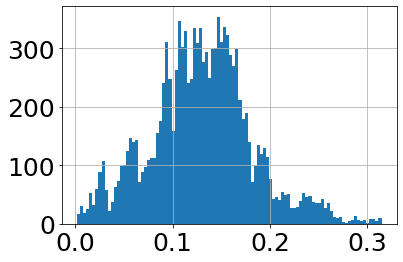

In [82]:
font = {'size': 25}

fig1, ax1 = plt.subplots()
linTB['Gaol'].hist(bins=100)
plt.rc('font', **font)
fig1.savefig('Hist_example_Gaol.pdf')

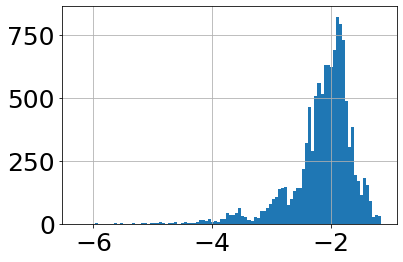

In [77]:
linTB['logGaol'] = np.log(linTB['Gaol'])

fig2, ax2 = plt.subplots()
linTB['logGaol'].hist(bins=100)
plt.rc('font', **font)
fig2.savefig('Hist_example_logGaol.pdf')

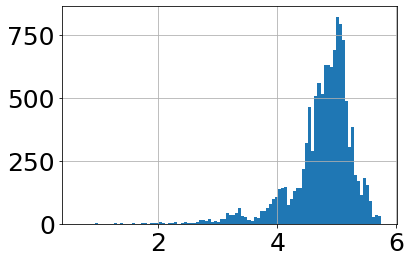

In [78]:
linTB['logGaol1000'] = np.log(linTB['Gaol']*1000)

fig5, ax5 = plt.subplots()
linTB['logGaol1000'].hist(bins=100)
plt.rc('font', **font)
fig5.savefig('Hist_example_logGaol1000.pdf')

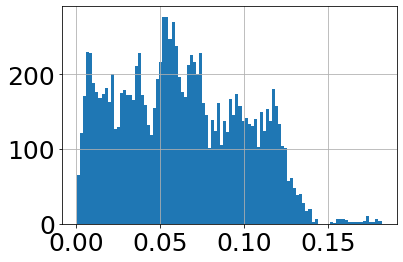

In [79]:
fig3, ax3 = plt.subplots()
linTB['Beach'].hist(bins=100)
plt.rc('font', **font)
fig3.savefig('Hist_example_Beach.pdf')

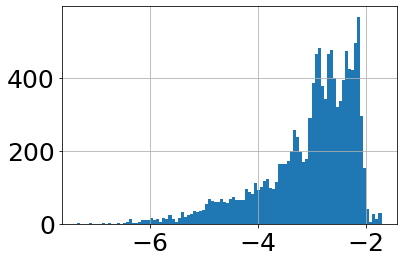

In [80]:
linTB['logBeach'] = np.log(linTB['Beach'])

fig4, ax4 = plt.subplots()
linTB['logBeach'].hist(bins=100)
plt.rc('font', **font)
fig4.savefig('Hist_example_logBeach.pdf')

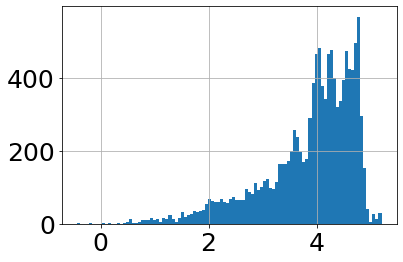

In [81]:
linTB['logBeach1000'] = np.log(linTB['Beach']*1000)

fig5, ax5 = plt.subplots()
linTB['logBeach1000'].hist(bins=100)
plt.rc('font', **font)
fig5.savefig('Hist_example_logBeach1000.pdf')